# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Цели и задачи проекта:


**Цели:** 

1. Провести исследование с целью построения модели машинного обучения, которая поможет определить регион, где добыча нефти принесёт наибольшую прибыль.

2. Результаты исследования позволят увеличить прибыль добывающей компании «ГлавРосГосНефть».

План выполнения :

1. **Загрузим и подготовим данные. Поясним порядок действий.**

2. **Обучим и проверим модель для каждого региона:**

    2.1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.

    2.2. Обучим модель и сделаем предсказания на валидационной выборке.

    2.3. Сохраним предсказания и правильные ответы на валидационной выборке.

    2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

    2.5. Проанализируем результаты.

3. **Подготовимся к расчёту прибыли:**

    3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.

    3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

    3.3. Напишем выводы по этапу подготовки расчёта прибыли.

4.  **Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:**

    4.1. Выберем скважины с максимальными значениями предсказаний.

    4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.

    4.3. Рассчитаем прибыль для полученного объёма сырья.

5. **Посчитаем риски и прибыль для каждого региона:**

    5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

    5.2. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

    5.3. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.



Признаки:

* id — уникальный идентификатор скважины
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)

Целевой признак:
* product — объём запасов в скважине (тыс. баррелей)
Условия задачи:

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import io
try:
   data0 = pd.read_csv('/datasets/geo_data_0.csv')
   data1 = pd.read_csv('/datasets/geo_data_1.csv')
   data2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
   data0 = pd.read_csv(r'D:\data_set\geo_data_0.csv')
   data1 = pd.read_csv(r'D:\data_set\geo_data_1.csv')
   data2 = pd.read_csv(r'D:\data_set\geo_data_2.csv')


### Изучим первый датасет 

In [3]:
display(data0.info())
display(data0.describe())
data0.head()
print('Сумма дубликатов:',data0.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Сумма дубликатов: 0


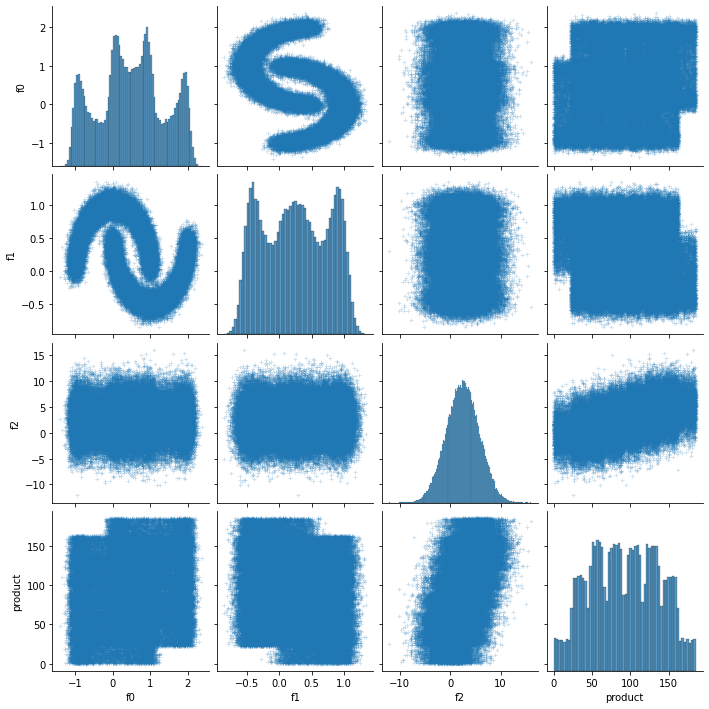

In [14]:
sns.pairplot(data0,plot_kws=dict(marker="+", linewidth=1,s=20,alpha=.2))

<AxesSubplot:>

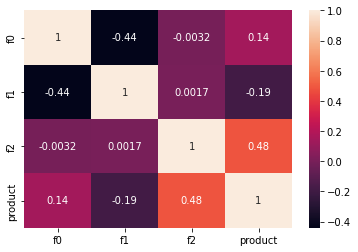

In [15]:
sns.heatmap(data0.corr(), annot = True)

Необычно распределены признаки f0,f1.Нормальное распределение только у f2,так же этот признак устойчиво коррелирует с целевым product. f0,f1 очень интересной взаимосвязью связаны, словно комплементарны друг к другу.Так же стоит отметить f0,f1 большое стандартное отклонение, больше среднего и медианы.Дубликатов и пропусков нет.  

### Изучим **второй** датасет

In [16]:
print(data1.info())
print(data1.describe())
print(data1.head())
print('Сумма дубликатов:',data1.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.7340

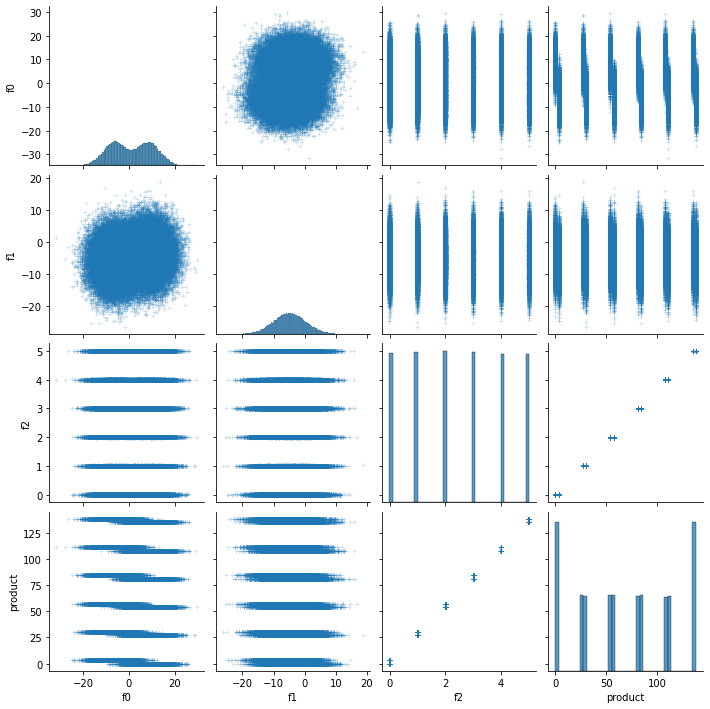

In [17]:
sns.pairplot(data1,plot_kws=dict(marker="+", linewidth=1,s=20,alpha=.2))

f0 имеет распределение как пересечение двух нормальных, видимо в этом регионе,  две переменные связанного с этим признаком. Так же двойственную происхождение, сохраняет для графика product- f0, c смешением для каждого столбца объёма запасы скважин. F1 нормально распределён, но большая часть значений меньше 0.  F2 имеет, градационное распределение и соответствует каждой градации product. Product – видимо скважины распределены возле небольшой числа месторождений 

### **Изучим** третий датасет

In [18]:
print(data2.info())
print(data2.describe())
print(data2.head())
print('Сумма дубликатов:',data2.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.8448

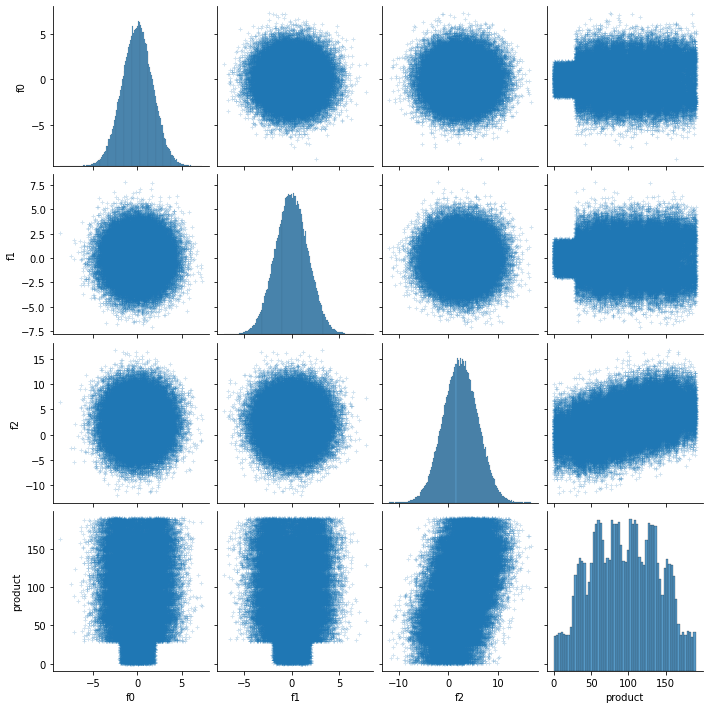

In [19]:
sns.pairplot(data2,plot_kws=dict(marker="+", linewidth=1,s=20,alpha=.2))

<AxesSubplot:>

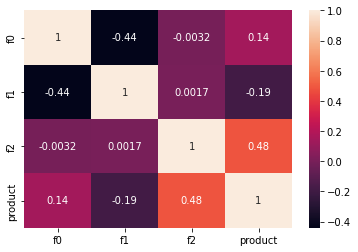

In [20]:
sns.heatmap(data0.corr(), annot = True)

Все три признака нормально распределены. Для f0 и f1   есть отрицательная корреляция. Так же график с продуктом имеет маленькую вариативность вначале и большой разброс в конце.  F2 коррелирует с product

### Краткий  вывод по  трём датасетам:

1. в каждом регионе - по 100000 скважин и распределены индивидуально для каждого региона 
2. нет дубликатов и пропусков 
3. масштабировать не нужно 

<div class="alert alert-info" style="border-color: #0080FF; border-radius: 5px">
    <p><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></p>
    <p>Моя благодарочка).</p>     
</div>

## Обучение и проверка модели

2.1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.

2.2. Обучим модель и сделаем предсказания на валидационной выборке.

2.3. Сохраним предсказания и правильные ответы на валидационной выборке.

2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

Сделаем это цыклом по каждому региону

In [21]:
# Удалим столбцы с id и сохраним датасеты в список
all_data= [
    data0.drop('id', axis=1),
    data1.drop('id', axis=1),
    data2.drop('id', axis=1),
]

In [22]:
data0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [23]:
#Hапечатайте на экране средний запас предсказанного сырья и RMSE модели.
mean_product = [] 
model_rmse = [] 

#Сохраните предсказания и правильные ответы на валидационной выборке.
target_list = [] 
predictions_list = [] 
#Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
target_valid_sum = [] 
                                                                                               

for region in range(3): 
    data = all_data[region]
    #разбиваем на целивые и обучающие 
    

    features = data.drop('product', axis=1)
    target = data['product']
    

    # 2.1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25:
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state = 1234)
    
    # 2.2. Обучим модель и сделаем предсказания на валидационной выборке:
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    # 4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям:
    target_valid_sum.append(target_valid.sum())
    
    # 2.3. Сохраним предсказания и правильные ответы на валидационной выборке.
    target_list.append(target_valid.reset_index(drop=True))
    predictions_list.append(pd.Series(predictions))
    
    # 2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели:
    mean_product.append(predictions.mean())
    model_rmse.append(
        mean_squared_error(target_valid, predictions)**0.5
    )
    
avg = pd.DataFrame({'region':['geo_data_0','geo_data_1','geo_data_2'],
                          'mean_product':mean_product,
                          "RMSE":model_rmse}
)
avg

,region,mean_product,RMSE
0,geo_data_0,92.430460,37.562394
1,geo_data_1,68.802482,0.893934
2,geo_data_2,94.915738,40.103181


Линейная регрессия имеет rmse для региона 0 и 2 почти половину среднего продукта. Лишь для региона1 показала хороший результат 0.9.Такой результат, скорее всего достигнут благодаря f2 признаку.

## Подготовка к расчёту прибыли

#### 3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.

In [24]:
profit_per_unit_of_product = 450 # доход с каждой единицы продукта тыс. рублей на 1 тыс. баррелей
number_of_wells = 500 # количество скважин, которое исследуют при разведке региона
target_of_wells= 200 # количество лучших скважин, которые нужно выбрать для разработки в каждом регионе с помощью машинного обучения
butget =  10**10 # бюджет  на разработку скважин в регионе тыс. рублей, заложенный на 200 скважин

#### 3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 

In [26]:
# нужно бюджет поделить на количество лучших скважен умноженное на единицу продукта 
# ну  избавиться от тысячей 
volume = butget/(target_of_wells*profit_per_unit_of_product)
print('Объём сырья для безубыточной разработки новой скважины:',round(volume/1000,2))

Объём сырья для безубыточной разработки новой скважины: 111.11


In [27]:
avg.mean_product

0    92.430460
1    68.802482
2    94.915738
Name: mean_product, dtype: float64

Как видно средние запасы скважин гораздо меньше необходимого, поэтому случайный выбор нам не подходит. Нужно отобрать 200 окупаемых 

## Расчёт прибыли и рисков 

 #### 4.1. Выберите скважины с максимальными значениями предсказаний. 

In [30]:
def profit_volume(target, pred, count):
  # 4.1. Выберите скважины с максимальными значениями предсказаний. 
  pred_sorted = pred[target.index].sort_values(ascending=False)
  #Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
  volume = pred_sorted[:count].sum()
  #4.3.Рассчитайте прибыль для полученного объёма сырья.
  profit_pred =  volume * profit_per_unit_of_product*1000
  revenue  = profit_pred - butget
  return round(volume,2), round(revenue/10**6,2)

In [32]:
volume_list =[]
revenue_list =[]

for region in range(3):
  volume,revenue = profit_volume(
      target_list[region],
      predictions_list[region],
      target_of_wells)
  volume_list.append(volume)
  revenue_list.append(revenue)
df_revenue = pd.DataFrame({'region':['geo_data_0','geo_data_1','geo_data_2'],
                          'volume':volume_list,
                          "revenue":revenue_list}  
)
df_revenue

,region,volume,revenue
0,geo_data_0,30849.15,3882.12
1,geo_data_1,27738.86,2482.49
2,geo_data_2,29996.33,3498.35


**Вывод:** Все регионы потенциально прибыльные, посчитаем прибыль и риски, чтобы найти наиболее выгодное решение 

## Посчитайте риски и прибыль для каждого региона:

In [34]:
def profit(target, pred, count):
  # 4.1. Выберите скважины с максимальными значениями предсказаний.
  sorted = pred.sort_values(ascending=False) 
  real_profit = target[sorted.index][:count]
  #Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
  volume = real_profit.sum()
  #4.3.Рассчитайте прибыль для полученного объёма сырья.
  profit_pred =  volume * profit_per_unit_of_product*1000
  revenue  = profit_pred - butget
  return  round(revenue/10**6,2)

### 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [50]:
# таблица 
df = pd.DataFrame(
       columns=['region',
               "revenue",
               'loss',
               'confidence_interval_low',
               'confidence_interval_high',
               ]
)
r = ['geo_data_0','geo_data_1','geo_data_2']
state = np.random.RandomState(12345)
#для графиков
hist_list =[]

# цикл по регионам 
for region in range(3):
  target = target_list[region] 
  predictions = predictions_list[region]
  
  # прибыль от 200 лучших скважин 
  revenue_list = []
  #Bootstrap с 1000 выборок 
  for i in range(1000):
    # извлечем 500 скважин из целевого 
    target_sample = target.sample(n=number_of_wells, replace=True, random_state=state)
    # и 500 для предсказанных 
    pred_sample = predictions[target_sample.index]
    target_sample = target_sample.reset_index(drop = True)
    pred_sample = pred_sample.reset_index(drop = True)
    # добавим прибыль от случайной выборки в 500 для 200 лучших 
    a = profit(target_sample,
               pred_sample,200 
               )
    revenue_list.append(a)
  # сделаем  series
  revenue_series = pd.Series(revenue_list)
  hist_list.append(revenue_series)

  #5.2. Найдите среднюю прибыль,
  mean_revenue = round(revenue_series.mean())
  
  # 5.2 95%-й доверительный интервал и риск убытков.
  # 2.5% с каждой стороны распределения прибыли
  confidence_interval_low = round(revenue_series.quantile(0.025), 2)
  confidence_interval_high = round(revenue_series.quantile(0.975), 2)
  
  #5.2 риск убытков - как доля меньше имеет отрицательную прибыль 
  loss =(revenue_series<0).sum()/len(revenue_series)*100
  
  # сохраним все в таблицу
  df.loc[region] = [r[region],mean_revenue,loss,confidence_interval_low,confidence_interval_high] 



In [51]:
df['confidence_interval'] = abs(df['confidence_interval_low']) + df['confidence_interval_high']
df

,region,revenue,loss,confidence_interval_low,confidence_interval_high,confidence_interval
0,geo_data_0,387,6.9,-164.57,872.44,1037.01
1,geo_data_1,419,1.8,26.00,803.76,829.76
2,geo_data_2,355,10.6,-172.94,889.16,1062.10


Как видно из таблицы самый низкий риск убытков для региона geo_data_1 в 1,8%
,так как наша модель достаточно точно предсказывает количество баррелей для этого региона. Далее идет   geo_data_0 с 6,9% и geo_data_2 с 10,6. Так же положительные значения нижней границы интервала только у geo_data_1.
Давайте посмотрим на графики.


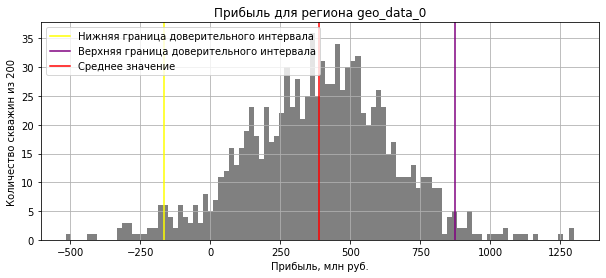

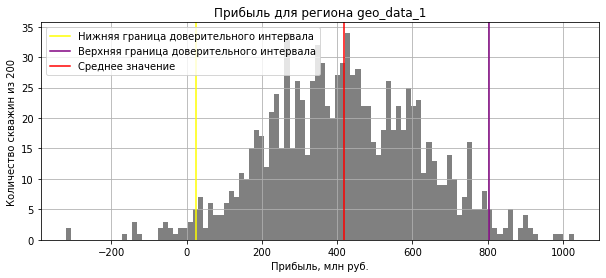

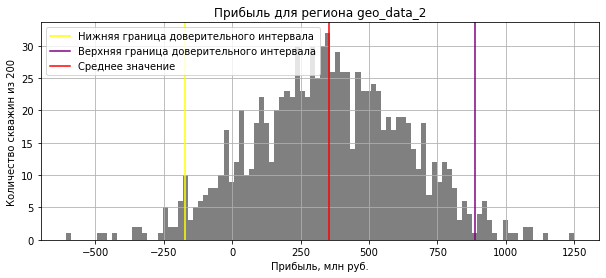

In [65]:
#график

for i in range(3):
  hist_list[i].hist(figsize=(10, 4), bins=100, color='grey')
  plt.grid(True)
  plt.axvline(hist_list[i].quantile(0.025), color='yellow')
  plt.axvline(hist_list[i].quantile(0.975), color='purple')
  plt.axvline(hist_list[i].mean(), color='red')
  plt.legend(['Нижняя граница доверительного интервала', 
                'Верхняя граница доверительного интервала','Среднее значение'])
  plt.xlabel('Прибыль, млн руб.')
  plt.ylabel('Количество скважин из 200')
  plt.title(f'Прибыль для региона geo_data_{i}')
  plt.show()


 Вывод:На графиках наглядно видно, что основное распределение прибыли для geo_data_1 лежит за границей нуля и меньше разброс данных, неудивительно, так как корень из среднеквадратичной ошибки самый маленький именно для этого региона. За счет чего имеет и высокую среднею прибыль в 419 млн и для инвесторов это лучший выбор.

In [ ]:
#график

for i in range(3):
    hist_list[i].hist(figsize=(10, 4), bins=100, color='grey')
    plt.grid(True)
    plt.axvline(hist_list[i].quantile(0.025), color='yellow')
    plt.axvline(hist_list[i].quantile(0.975), color='purple')
    plt.axvline(hist_list[i].mean(), color='red')
    plt.legend(['Нижняя граница доверительного интервала', 
                'Верхняя граница доверительного интервала','Среднее значение'])
    plt.xlabel('Прибыль, млн руб.')
    plt.ylabel('Количество скважин из 200')
    plt.title(f'Прибыль для региона geo_data_{i}')
    plt.show()

# Общий вывод:

В этом проекте мы:
* Провели анализ данных, перед построением модели 
* Обучили построили модель линейной регрессии с целью узнать какой из регионов принесет наибольшую прибыль,  применили метрику rmse
* Также применили техникой Bootstrap для анализа возможных рисков и прибыль
* Через порог риска в  2,5% перешел регион geo_data_1 с 1.8%
,также он имеет наибольшую потенциальную прибыль в 419 млн рублей
* Поэтому для инвестиций рекомендуется именно этот регион 
